In [7]:
import numpy as np
from scipy.stats import anderson_ksamp
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns
import trimesh

In [ ]:
num_points = 100
dist1 = np.random.rand(num_points)
dist2 = np.random.randn(num_points)
dist3 = np.random.rand(num_points) 

In [ ]:
fig, ax = plt.subplots(1,1)
ax.hist(dist1, histtype="step")
ax.hist(dist2, histtype="step")
ax.hist(dist3, histtype="step")
plt.show()

In [ ]:
tmp = anderson_ksamp([dist3, dist1])
ad_stat = tmp.significance_level
ad_stat = (ad_stat - 0.001)/ (0.25 - 0.001)
print(ad_stat)

In [ ]:
tmp

TODO: try reading in multiple all_pos by creating a list of dictionaries of all_pos

In [8]:
all_pos_path = [
     "../../out/analyze/peroxisomes/spheresSST/all_positions_peroxisomes_grid_spacing_20.json",
     "../../out/analyze/peroxisomes/spheresSST/all_positions_peroxisomes_grid_spacing_2pt5.json",
]
all_pos_list = []
for file_path in all_pos_path:
     with open(file_path, 'r') as j:
          all_pos_list.append(json.loads(j.read()))

TODO: loop over the list of all_pos, use index of loop as a seed suffix

In [9]:
all_objs = {}
packing_label = ["coarse", "fine"]
for packing_id, all_pos in enumerate(all_pos_list):
    for seed, object_dict in all_pos.items():
        for obj, positions in object_dict.items():
            positions = np.array(positions)
            if obj not in all_objs:
                all_objs[obj] = {}
            seed_key = f"{seed}_{packing_label[packing_id]}"
            if seed_key not in all_objs[obj]:
                all_objs[obj][seed_key] = {}
            for ct, dim in enumerate(["x", "y", "z"]):
                all_objs[obj][seed_key][dim] = positions[:, ct]

In [ ]:
ingr_key = "membrane_interior_peroxisome"
num_seeds = len(all_objs[ingr_key])
similarity = np.zeros((3, num_seeds, num_seeds))
score = np.zeros((3, num_seeds, num_seeds))
key_list = list(all_objs[ingr_key].keys())
similarity_df = pd.DataFrame(index=key_list,columns=pd.MultiIndex.from_product([["x", "y", "z"], key_list]), dtype=float)
similarity_df['packing_id'] = 0

for rc, (seed1, pos_dict1) in enumerate(all_objs[ingr_key].items()):
    similarity_df.loc[seed1, 'packing_id'] = seed1.split('_')[-1]
    for cc, (seed2, pos_dict2) in enumerate(all_objs[ingr_key].items()):
        for dc, dim in enumerate(["x", "y", "z"]):
            arr1 = pos_dict1[dim]
            arr2 = pos_dict2[dim]
            if len(arr1)==1 or len(arr2)==1:
                scaled_sig = 0.25
                score_val = 0
            else:
                ad_stat = anderson_ksamp([arr1, arr2]) 
                scaled_sig = (ad_stat.significance_level - 0.001) / (0.25 - 0.001)
                score_val = ad_stat.statistic
            similarity[dc, rc, cc] = similarity_df.loc[seed1, (dim, seed2)] = scaled_sig
            score[dc, rc, cc] = score_val

In [10]:
df_packing = similarity_df["packing_id"]
lut = dict(zip(df_packing.unique(), sns.color_palette()))
row_colors = df_packing.map(lut)

Text(0.5, 32.7222222222222, 'y')

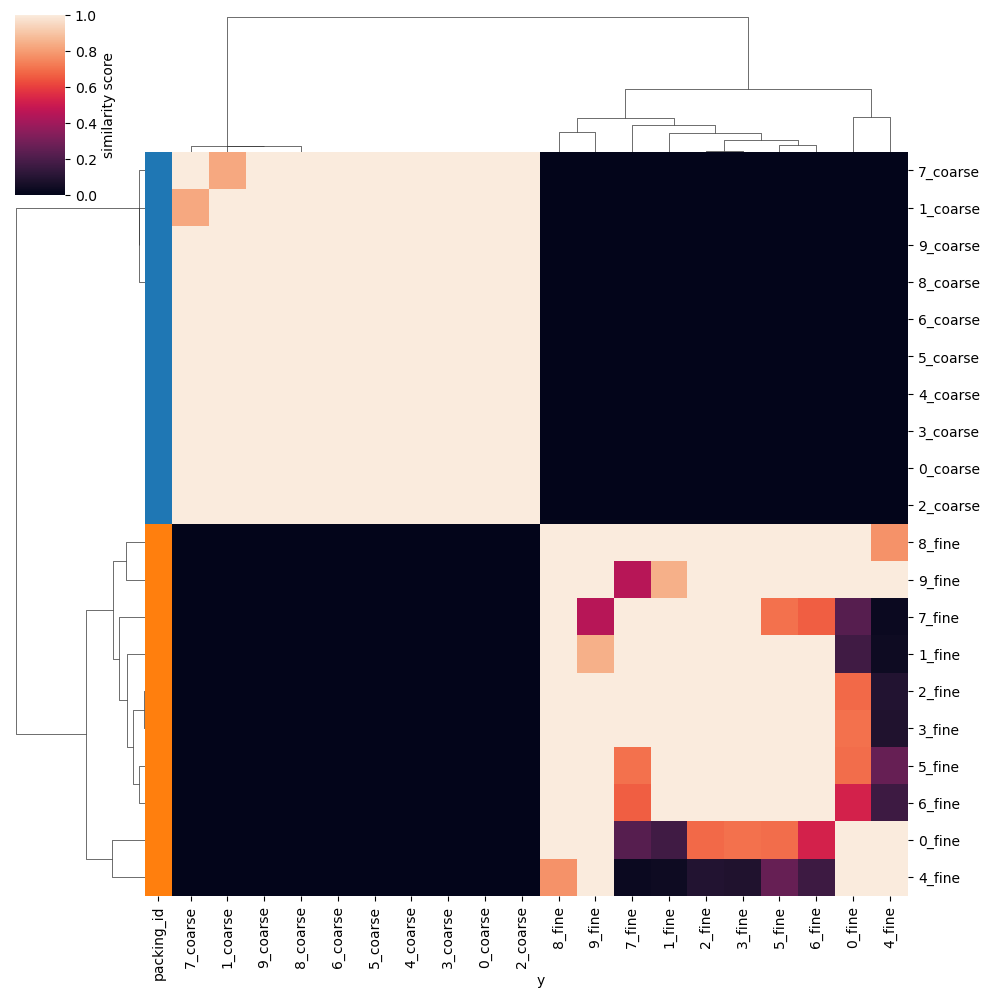

In [11]:
dim = "y"
g = sns.clustermap(similarity_df[dim], row_colors=row_colors, dendrogram_ratio=(0.15, 0.16), cbar_kws={"label": "similarity score"})
g.ax_heatmap.set_xlabel(dim)

In [12]:
theta_vals = np.arange(0, np.pi, np.pi/64)
phi_vals = np.arange(0, 2 * np.pi, np.pi/64)

In [ ]:
vec_list = []
for theta in theta_vals:
    for phi in phi_vals:
        vec_list = [np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]

In [13]:
mem_path = "../../data/mean-membrane.obj"
nuc_path = "../../data/mean-nuc.obj"

mem_mesh = trimesh.load_mesh(mem_path)
nuc_mesh = trimesh.load_mesh(nuc_path)

unable to load materials from: mean-membrane.mtl
specified material (None)  not loaded!
unable to load materials from: mean-nuc.mtl
specified material (None)  not loaded!


In [14]:
for packing_dict in all_pos_list:
    for seed, pos_dict in packing_dict.items():
        pos_list = np.array(pos_dict[ingr_key])

In [ ]:
locations, _, _ = nuc_mesh.ray.intersects_location(
            ray_origins=[[0, 0, 0]],
            ray_directions=[vec]
        )

In [21]:
def cartesian_to_sph(xyz):
    sph_pts = np.zeros(xyz.shape)
    xy = xyz[:, 0] ** 2 + xyz[:, 1] ** 2
    sph_pts[:,0] = np.sqrt(xy + xyz[:,2]**2)
    sph_pts[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2])
    sph_pts[:,2] = np.arctan2(xyz[:,1], xyz[:,0]) + np.pi

    return sph_pts

In [22]:
sph_pts = cartesian_to_sph(pos_list)

In [ ]:
locations